In [1]:
from dataclasses import dataclass

import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.components.cdvi.cmcd import CMCD
from src.components.cdvi.dis import DIS
from src.components.cdvi.ula import ULA
from src.components.control.aggr_control import AggrControl
from src.components.dvinp import DVINP
from src.components.encoder.proj_encoder import ProjEncoder
from src.components.schedule.annealing_schedule import AnnealingSchedule
from src.components.schedule.cos_noise_schedule import CosineNoiseSchedule
from src.components.schedule.noise_schedule import NoiseSchedule
from src.components.schedule.step_size_schedule import StepSizeSchedule
from src.train.static_trainer import BetterStaticTargetTrainer
from src.utils.datasets import ContextTestDataset
from src.utils.distros import ContextualGMM

In [2]:
device = torch.device("cpu") 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "GELU"
    use_score = False
    learning_rate = 3e-3
    size = 64
    batch_size = 64

config = Config()

In [4]:
dataset = ContextTestDataset(size=config.size, c_dim=config.c_dim, sampling_factor=0)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
contextual_target = lambda context, _: ContextualGMM(context, offsets=(5, -5), scales=(1, 1), weights=(0.3, 0.7))

encoder = ProjEncoder(
    c_dim=config.c_dim, 
    h_dim=config.h_dim
)

control = AggrControl(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps,
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    use_score=config.use_score
)

# noise_schedule = NoiseSchedule(
#     z_dim=config.z_dim,
#     num_steps=config.num_steps, 
#     device=device,
# )

noise_schedule = CosineNoiseSchedule(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    device=device
)

step_size_schedule = StepSizeSchedule(
    num_steps=config.num_steps, 
    device=device
)

annealing_schedule = AnnealingSchedule(
    num_steps=config.num_steps, 
    device=device
)

cdvi = DIS(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control=control, 
    step_size_schedule=step_size_schedule,
    noise_schedule=noise_schedule,
    annealing_schedule=annealing_schedule,
    use_score=config.use_score,
    device=device, 
)

# cdvi = CMCD(
#     z_dim=config.z_dim, 
#     num_steps=config.num_steps, 
#     control=control,
#     step_size_schedule=step_size_schedule,
#     noise_schedule=noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device, 
# )

# cdvi = ULA(
#     z_dim=config.z_dim, 
#     num_steps=config.num_steps, 
#     step_size_schedule=step_size_schedule,
#     noise_schedule=noise_schedule,
#     annealing_schedule=annealing_schedule,
#     device=device, 
# )

dvinp = DVINP(
    encoder=encoder,
    cdvi=cdvi,
    decoder=None,
    contextual_target=contextual_target
).to(device)

In [6]:
optimizer = torch.optim.AdamW(params=dvinp.parameters(), lr=config.learning_rate)

trainer = BetterStaticTargetTrainer(
    device=device,
    dvinp=dvinp,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    wandb_logging=False,
    num_subtasks=1,
    num_samples=1
)

In [19]:
num_epochs = 500

losses = trainer.train(
    num_epochs=num_epochs, 
    max_clip_norm=None,
    alpha=None
)

100%|██████████| 1/1 [00:00<00:00, 47.88it/s, epoch=499, loss=2.99]


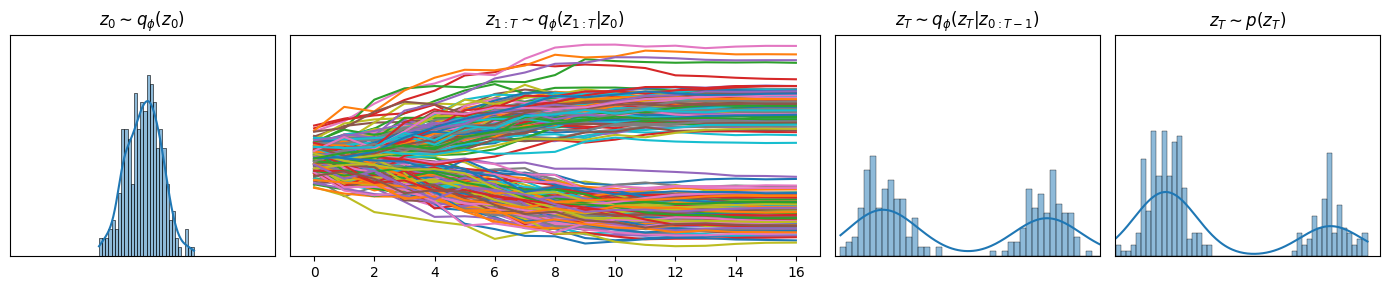

In [26]:
num_samples = 256

context = dataset.sampling_factor * torch.ones((1, num_samples, 1, config.c_dim), device=device)
target = dvinp.contextual_target(context, None)

r = dvinp.encoder(context.to(device), None)
_, _, z_samples = dvinp.cdvi.run_chain(target, r, None)

z_0_samples = z_samples[0].detach().cpu().numpy()
z_T_samples = z_samples[-1].detach().cpu().numpy()
z_trajectories = [[z[0, i, 0].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]
z_target_samples = target.sample().detach().cpu().numpy()

z_0_samples = z_0_samples.reshape(-1)
z_T_samples = z_T_samples.reshape(-1)
z_target_samples = z_target_samples.reshape(-1)

fig, ax = plt.subplots(1, 4, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 2, 1, 1]})

sns.histplot(z_0_samples, ax=ax[0], stat="density", bins=30, kde=True)
ax[0].set_title("$z_0\sim q_\phi(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-8, 8)
ax[0].set_ylim(0, 0.5)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("$z_{1:T}\sim q_\phi(z_{1:T}|z_0)$")

sns.histplot(z_T_samples, ax=ax[2], stat="density", bins=50, kde=True)
ax[2].set_title("$z_T\sim q_\phi(z_T|z_{0:T-1})$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-8, 8)
ax[2].set_ylim(0, 0.5)

sns.histplot(z_target_samples, ax=ax[3], stat="density", bins=50, kde=True)
ax[3].set_title("$z_T\sim p(z_T)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-8, 8)
ax[3].set_ylim(0, 0.5)

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

ax[0].set_xticks([])

ax[2].set_xticks([])
ax[3].set_xticks([])

plt.tight_layout()
plt.show()